<a href="https://colab.research.google.com/github/Calaria/pytorch_models/blob/main/09_PyTorch_Model_Deployment_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# get torchinfo
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

# Creating an ViT feature extractor

In [ ]:
def create_vit_model(num_classes:int=3,
                   seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes))
  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model(num_classes=101,
                                      seed=42)

In [ ]:
#Get summary of the model
from torchinfo import summary
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

In [ ]:
print(f"Testing transforms:\n{vit_transforms}")
print(f"Training transforms:\n{food101_train_transforms}\n")

Testing transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)



# Get Data

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,
                              download=True)


In [ ]:
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms,
                             download=True)

In [ ]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Create a subset

In [ ]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int =42):
  length_1=int(len(dataset)*split_size)
  length_2=int(len(dataset)-length_1)
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                [length_1, length_2],
                                                                 generator=torch.manual_seed(seed))
  return random_split_1, random_split_2

In [ ]:
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

# Turn dataset into dataloader

In [ ]:
import os
import torch

BATCH_SIZE = 32
BUM_WORKERS = 2 if os.cpu_count() <=4 else 4

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=BUM_WORKERS)
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False,
                                                                num_workers=BUM_WORKERS)

# Training Model

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
vit_food101_results = engine.train(model=vit,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


# Inspect loss curves

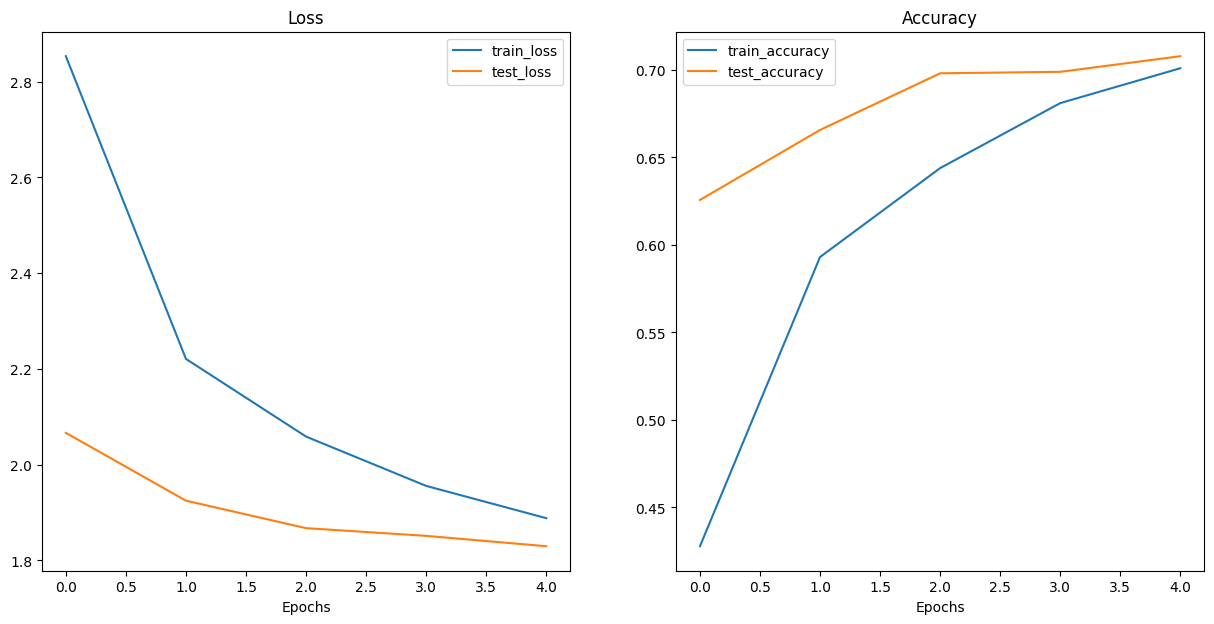

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_food101_results)

# Save and Load

In [ ]:
from going_modular.going_modular import utils

vit_food101_model_path = "pretrained_vit_feature_extractor_food101_20_percent.pth"

utils.save_model(model=vit,
                 target_dir="models",
                 model_name=vit_food101_model_path)

[INFO] Saving model to: models/pretrained_vit_feature_extractor_food101_20_percent.pth


In [ ]:
#load
loaded_vit_food101, vit_transforms = create_vit_model(num_classes=101)
loaded_vit_food101.load_state_dict\
 (torch.load("models/pretrained_vit_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

# ChecK Model Size

In [ ]:
from pathlib import Path
pretrained_vit_food101_model_size = Path("models", vit_food101_model_path)\
.stat().st_size // (1024*1024)
print(f"Model size: {pretrained_vit_food101_model_size} MB")


Model size: 327 MB


# Deploy The Big Model

In [ ]:
from pathlib import Path

foodvision_big_demo_path = Path("demos/foodvision_big/")

foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

# move an example image

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

!mv models/pretrained_vit_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2024-05-28 12:20:11--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2024-05-28 12:20:11 (65.6 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



In [ ]:
# import os
# import glob
# import shutil

# def get_jpg_images(directory):
#     images = glob.glob(os.path.join(directory, '*.jpg'))
#     return images[0]
# directory_path = '/content/data/food-101/images/apple_pie'
# path=get_jpg_images(directory_path)

# Saving Food101 class names to class_names.txt

In [ ]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Read class names file
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

# model.py

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
import os

from torch import nn

def create_vit_model(num_classes:int=3,
                   seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes))
  return model, transforms

Overwriting demos/foodvision_big/model.py


# Create app.py

In [ ]:
%%writefile demos/foodvision_big/app.py
import os
import gradio as gr
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open("class_names.txt","r") as f:
    class_names = [food_name.strip() for food_name in  f.readlines()]
vit, vit_transforms = create_vit_model(num_classes=101,
                                      seed=42)
vit.load_state_dict(
    torch.load(
        f="pretrained_vit_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),
    )
)
def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    # Transform the image
    img = vit_transforms(img).unsqueeze(0)

    vit.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(vit(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

title = "FoodVision Big"
description = "An ViT feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app
demo.launch()

Overwriting demos/foodvision_big/app.py


# Create a requirements file

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Overwriting demos/foodvision_big/requirements.txt


# Download app files

In [ ]:
# Zip foodvision_big folder
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

updating: app.py (deflated 51%)
updating: class_names.txt (deflated 48%)
updating: examples/ (stored 0%)
updating: examples/04-pizza-dad.jpg (deflated 0%)
updating: model.py (deflated 47%)
updating: requirements.txt (deflated 4%)
  adding: pretrained_vit_feature_extractor_food101_20_percent.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>